### Übung 2b
FFNN zur Vorhersage des Median House Income

In [3]:
import pandas as pd

data = pd.read_csv("../../data/housing.csv")

#### Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# trennen in input und output Features
input_feature_names = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'ocean_proximity'
]

output_feature_names = ["median_house_value"]

# Datenset horizontal in input/output features splitten
X = data[input_feature_names]
y = data[output_feature_names]

In [6]:
# trennen in nummerische und nicht-numerische Features
numeric_feature_names = list(X.select_dtypes(include=['number']).columns)
nonnumeric_feature_names = list(X.select_dtypes(exclude=['number']).columns)

# train/test Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=1239
)

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion

In [7]:
class FeatureSelector:
    
    """This transformer lets you pick columns from a pandas dataset based on name
    
    :param features: List of feature names to select
    :type features: List of strings
    :param debug: Switch to send output to debug console
    :type debug: Boolean
    :raises: ValueError if features is not of type list
    """
    
    def __init__(self, features=[]):
        
        if type(features) != list:
            raise ValueError("Input features must be of type List.")
        
        self.c = features

    def fit(self, X, y=None):
        """This method passes-on the object as no fitting is required
        
        :param X: Input matrix
        :type X: Numpy matrix
        :param y: Output vector
        :type y: Numpy array
        :returns: self
        """
        return self

    def transform(self, X):
        """This method transforms the input data by selecting the features
        
        :param X: Input matrix
        :type X: Numpy matrix
        :param y: Output vector
        :type y: Numpy array
        :returns: Selected colums as Numpy matrix
        """
        return X[self.c]

#### Pipelines

In [9]:
X_pipeline = Pipeline([
    ("union", FeatureUnion([
        ("numeric", Pipeline([
            ("select_numeric_features", FeatureSelector(features=numeric_feature_names)),
            ("replacing_missing_values", SimpleImputer(strategy="mean")),
            ("scale_values", MinMaxScaler())
        ])),
        ("non-numeric", Pipeline([
            ("select_non-numeric_features", FeatureSelector(features=nonnumeric_feature_names)),
            ("replacing_missing_values", SimpleImputer(strategy="constant", fill_value="missing")),
            ("encode_values", OneHotEncoder())
        ]))
    ]))
])

In [10]:
y_pipeline = Pipeline([
    ("scale", MinMaxScaler())
])

In [11]:
X_pipeline.fit(X_train)
X_train_processed = X_pipeline.transform(X_train)
X_test_processed = X_pipeline.transform(X_test)

In [12]:
y_pipeline.fit(y_train)
y_train_processed = y_pipeline.transform(y_train)
y_test_processed = y_pipeline.transform(y_test)

#### Shape prüfen

In [14]:
print("Shape of train set:", X_train_processed.shape)
print("Shape of test set:", X_test_processed.shape)

Shape of train set: (14448, 13)
Shape of test set: (6192, 13)


### FFNN erstellen

In [17]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)

Das FFNN besteht aus 3 Dense Layern. Als Loss Funktion habe ich für das Regressionsproblem den MSE ausgewählt und als Optimizer den Stochastic Gradient Descent.

In [48]:
network = keras.models.Sequential()

In [49]:
input_shape = X_train_processed.shape

In [51]:
# Add fully connected layer with a ReLU activation function
network.add(keras.layers.Dense(units=32, activation='relu', input_shape=(X_train_processed.shape[1],)))

# Add fully connected layer with a ReLU activation function
network.add(keras.layers.Dense(units=32, activation='relu'))

# Add fully connected layer with no activation function
network.add(keras.layers.Dense(units=1))

In [52]:
loss_fct = keras.losses.mean_squared_error
optim    = keras.optimizers.SGD()
metrics  = [keras.metrics.MeanSquaredError]

In [56]:
network.compile(loss='mse', # Mean squared error
                optimizer='RMSprop', # Optimization algorithm
                metrics=['mse']) # Mean squared error

In [74]:
#X_train_processed = X_train_processed.toarray()
#y_train_processed = y_train_processed.toarray()
X_test_processed = X_test_processed.toarray()
#y_test_processed = y_test_processed.toarray()

In [69]:
history = network.fit(X_train_processed , y_train_processed, epochs=100, batch_size=64)

Train on 14448 samples
Epoch 1/100
14448/14448 [==============================] - 1s 59us/sample - loss: 0.0392 - mse: 0.0392
Epoch 2/100
14448/14448 [==============================] - 0s 29us/sample - loss: 0.0219 - mse: 0.0219
Epoch 3/100
14448/14448 [==============================] - 0s 25us/sample - loss: 0.0205 - mse: 0.0205
Epoch 4/100
14448/14448 [==============================] - 0s 25us/sample - loss: 0.0197 - mse: 0.0197
Epoch 5/100
14448/14448 [==============================] - 0s 27us/sample - loss: 0.0191 - mse: 0.0191
Epoch 6/100
14448/14448 [==============================] - 0s 24us/sample - loss: 0.0186 - mse: 0.0186
Epoch 7/100
14448/14448 [==============================] - 0s 25us/sample - loss: 0.0182 - mse: 0.0182
Epoch 8/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0180 - mse: 0.0180
Epoch 9/100
14448/14448 [==============================] - 0s 25us/sample - loss: 0.0176 - mse: 0.0176
Epoch 10/100
14448/14448 [========================

In [75]:
test_hist_1 = network.evaluate(X_test_processed, y_test_processed)

6192/6192 [==============================] - 0s 43us/sample - loss: 0.0137 - mse: 0.0137


In [82]:
def plot_training_curves(train_hists, test_hists, metric="sparse_categorical_accuracy"):
    """
    Helper function for plotting training curves from tf-keras history objects
    """ 
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    train_hist_loss     = sum([x.history['loss']     for x in train_hists], [])
    #train_hist_val_loss = sum([x.history['val_loss'] for x in train_hists], [])
    ax[0].plot(train_hist_loss)
    #ax[0].plot(train_hist_val_loss)
    for x in test_hists:
        ax[0].axhline(y=x[0], color="green", ls="--")
    ax[0].set_title('Loss history')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train',  'Test'], loc='upper right')
    
    train_hist_acc     = sum([x.history[metric]          for x in train_hists], [])
    #train_hist_val_acc = sum([x.history['val_' + metric] for x in train_hists], [])
    ax[1].plot(train_hist_acc)
    #ax[1].plot(train_hist_val_acc)
    for x in test_hists:
        ax[1].axhline(y=x[1], color="green", ls="--")
    ax[1].set_title('MSE history')
    ax[1].set_ylabel('MSE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='lower right')

In [83]:
from matplotlib import pyplot as plt

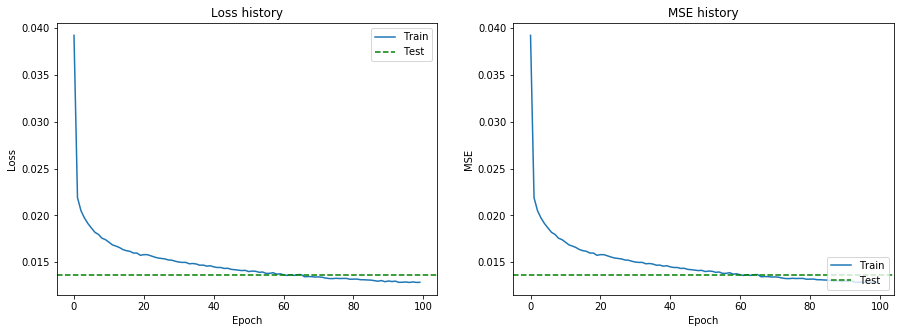

In [84]:
plot_training_curves([history], [test_hist_1], metric="mse")

Im Plot der Kurve sieht man sehr gut, wie zu Beginn der Loss sehr stark abnimmt in den ersten 10 Epochen. Danach verbessert sich das Modell nur noch leicht.

In [85]:
print("Test loss:\t", test_hist_1[0])
print("Test MSE:\t", test_hist_1[1])

Test loss:	 0.013660780944709862
Test MSE:	 0.0136607895


In [86]:
train_hist_2 = network.fit(X_train_processed , y_train_processed, epochs=100, batch_size=64)
test_hist_2  = network.evaluate(X_test_processed, y_test_processed)

Train on 14448 samples
Epoch 1/100
14448/14448 [==============================] - 0s 28us/sample - loss: 0.0128 - mse: 0.0128
Epoch 2/100
14448/14448 [==============================] - 0s 27us/sample - loss: 0.0128 - mse: 0.0128
Epoch 3/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0127 - mse: 0.0127
Epoch 4/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0127 - mse: 0.0127
Epoch 5/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0127 - mse: 0.0127
Epoch 6/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0126 - mse: 0.0126
Epoch 7/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0126 - mse: 0.0126
Epoch 8/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0127 - mse: 0.0127
Epoch 9/100
14448/14448 [==============================] - 0s 26us/sample - loss: 0.0126 - mse: 0.0126
Epoch 10/100
14448/14448 [========================

In [87]:
print("Test loss:\t", test_hist_2[0])
print("Test MSE:\t", test_hist_2[1])

Test loss:	 0.012620074173931312
Test MSE:	 0.012620073


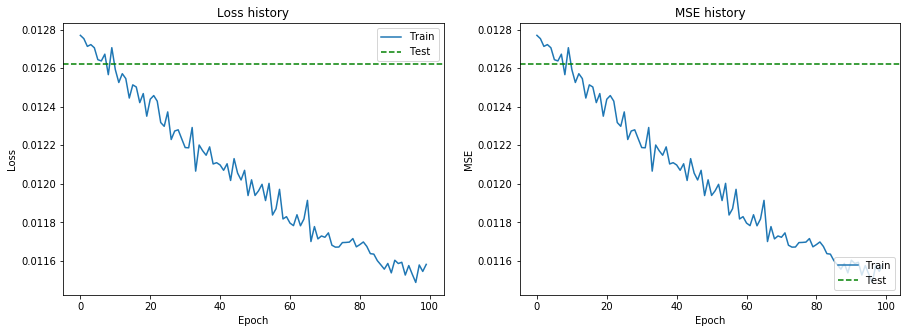

In [88]:
plot_training_curves([train_hist_2], [test_hist_2], metric="mse")

Beim 2 Trainingsdurchlauf hat sich das FFNN kontiniuerlich leicht gesteigert und durch den 2. Trainingsdurchlauf konnte der Test MSE auch noch leicht verringert werden.